In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
_include_('curriculum_vqa')

from cvqa.curriculum import plotter, VQAInstanceDistribution2
from cvqa import trainers, datasets, viz

concept_dict = {
        'color': ['blue', 'brown', 'cyan', 'gray'],  # , 'green', 'purple', 'red', 'yellow'],
        'material': ['metal', 'rubber', 'plastic'],
        'shape': ['triangle', 'circle', 'square']
    }

# vqa_dist = VQAInstanceDistribution2(concept_dict=concept_dict, prompt_types_filter=['retrieve_attribute'], d_img=24)
vqa_dist = VQAInstanceDistribution2(concept_dict=concept_dict, d_img=24)

Img Encoder: Loss=0.000: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


In [3]:
# ds_temp = vqa_dist.sample_dataset(images=20, prompts_per_image=3)
# VQAInstanceDistribution2.to_debug_rep(ds_temp)

In [4]:
import random
import numpy as np
import torch

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

ds_train, ds_dev = datasets.Curriculum.from_samples(
    vqa_dist.sample_dataset(images=1000, prompts_per_image=5),
    vqa_dist.sample_dataset(images=100, prompts_per_image=5),
)

ds_train

Root: - 
Samples: 2891 (N_prompt=9, N_target=1)
Concepts: 0 
Classes: 0 
Prompt Vocab Tokens:43 
Answer Vocab Tokens:21 

In [5]:
trainer = trainers.VQATrainer(log_dir=None, progressbar='epochs')

def train_model(model, lr=1e-4, lr_decay_step_size=None, epochs=10, batch_size=32):
    
    tracker = None
#     tracker = traintracks.TrainTracker(root='traintracks/eval')
#     tracker.save_module(sys.modules['cvqa.models2'])
#     tracker.log_conf(model.args)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step_size, gamma=0.1)
    
    train_loss, train_acc, dev_acc = trainer.train(
        model, ds_train, ds_dev, 
        optimizer, 
        optim_sched=scheduler,
        traintracker=tracker, num_epochs=epochs, batch_size=batch_size
    )
    
    return {
        'train_loss': train_loss, 
        'train_acc': train_acc, 
        'dev_acc': dev_acc
    }

[epoch=14, steps=1350, train_acc=1.00, dev_acc=0.98] loss: 0.054: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


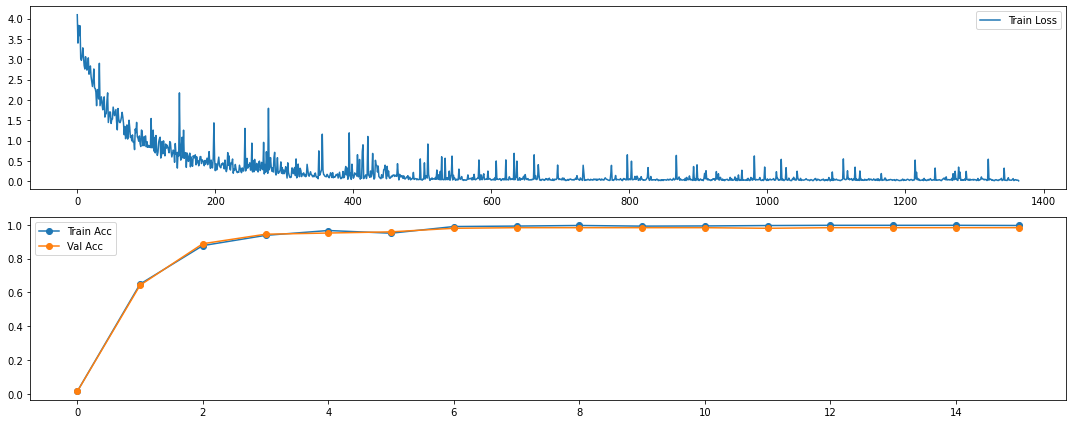

In [6]:
import numpy as np
import torch
from cvqa.model_dev import answer_model

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

args = answer_model.default_args()
args['d_a'] = 4
args['d_w'] = args['d_c'] = 24
args['d_o'] = 24
args['d_k'] = 8
    
model = answer_model.ParentModel(ds_train.vocab, ds_train.ans_vocab, args)

# print(trainer.evaluate(model, torch.utils.data.DataLoader(ds_train, batch_size=32)))

train_metrics = train_model(model, lr=3e-3, lr_decay_step_size=500, epochs=15, batch_size=32)

viz.plot_training(**train_metrics)

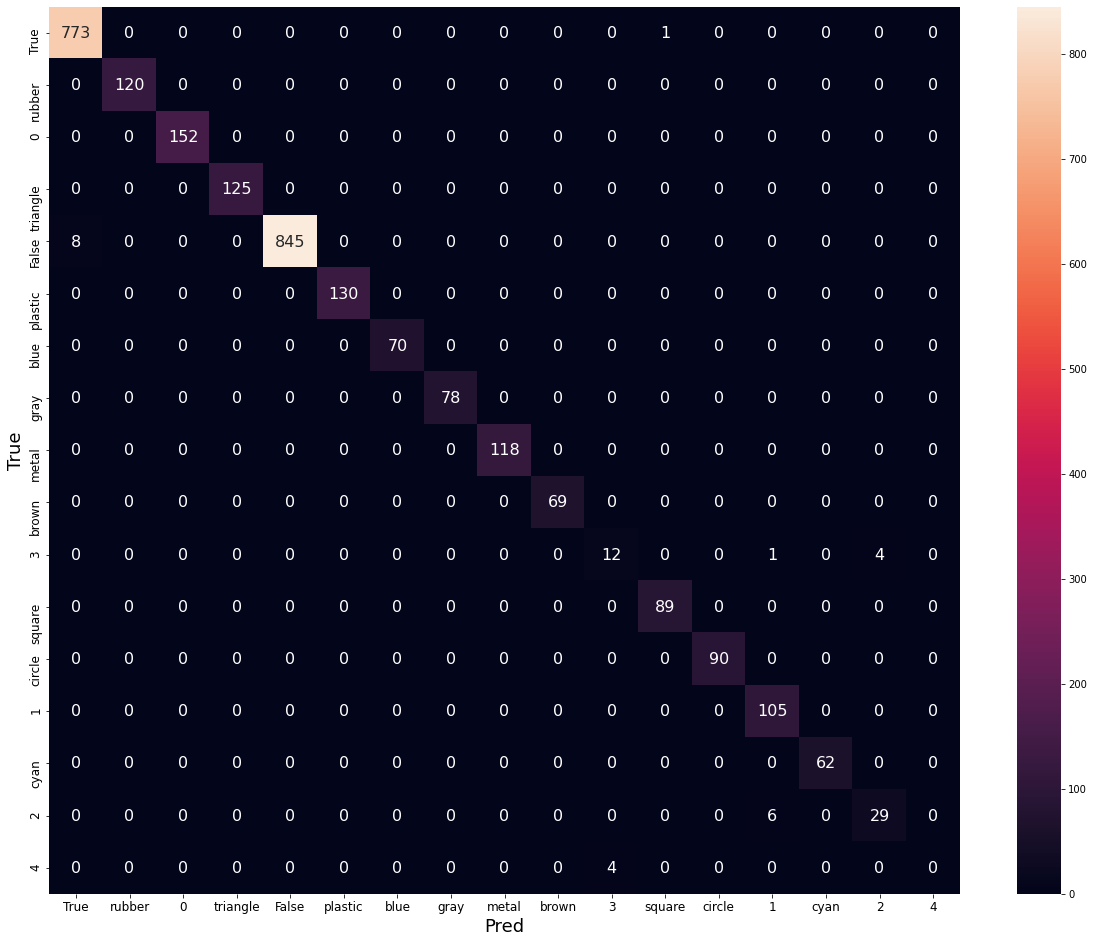

In [123]:
y_true, y_pred = trainer.get_predictions(model, ds_train)
viz.one_word_conf_mat(y_true, y_pred, ds_dev.ans_vocab)

In [11]:
import pandas as pd

y_true, y_pred = trainer.get_predictions(model, ds_dev)

questions = []
y_true_str = []
y_pred_str = []
for i, s in enumerate(ds_dev.samples):
    questions.append(s['prompt'])
    y_true_str.append(ds_train.ans_vocab.string(y_true[i]))
    y_pred_str.append(ds_train.ans_vocab.string(y_pred[i]))
    
    
res = pd.DataFrame({
    'question': questions,
    'y_true': y_true_str,
    'y_pred': y_pred_str
})

res[res['y_true'] != res['y_pred']]

,question,y_true,y_pred
35,Are there 0 blue items ?,True,False
51,Are there 3 brown squares ?,False,True
78,Are there 3 cyan triangles ?,False,True
84,How many blue items are there ?,<unk>,2
87,How many triangles are there ?,4,2
126,What color is the triangle ?,blue,gray
175,There are no circles,False,True
192,Are there 2 blue circles ?,False,True
197,Are there 2 brown rubber items ?,True,False
200,Are there 4 plastic items ?,True,False


In [13]:
ds_train.samples[27]

{'viz_rep': {'objects': [{'location': [0.16, 0.49],
    'size': 0.09,
    'color': 'blue',
    'material': 'metal',
    'shape': 'triangle'}],
  'encoded': tensor([[-2.4746e+00,  1.9000e+00, -6.2275e-01,  3.5596e+00,  2.5803e+00,
            2.6179e+00,  2.9209e+00,  2.0035e+00, -3.4307e+00,  1.1531e+00,
            1.4751e+00, -2.4812e+00,  2.0953e+00, -2.0772e+00, -3.1847e+00,
           -2.2914e-03,  1.7350e-01,  4.6629e-01,  1.1887e-01,  1.6879e-01,
            4.3147e-01,  4.0994e-02,  1.6278e-01,  4.5869e-01],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+0